In [2]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import  DateFormatter
import datetime
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [25]:
projectid = "ebmdatalab"
ccg_df = pd.read_gbq("""
SELECT
  glargine.month as period,
  glargine.pct,
  SUM(CASE
      WHEN SUBSTR(glargine.bnf_code,1,11)='0601012V0AA' THEN items
      ELSE 0 END) AS generic_items,
  SUM(CASE
      WHEN SUBSTR(glargine.bnf_code,1,11)='0601012V0BB' THEN items
      ELSE 0 END) AS lantus_items, 
SUM(CASE
      WHEN SUBSTR(glargine.bnf_code,1,11)='0601012V0BD' THEN items
      ELSE 0 END) AS abasaglar_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(glargine.bnf_code,1,11) = '0601012V0BD' THEN items
        ELSE 0 END), SUM(items)) AS biosimilar_percent
 
FROM
ebmdatalab.richard.glargine AS glargine
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  glargine.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and glargine.month  >='2015-01-01 00:00:00'
GROUP BY
  period,
  pct
ORDER BY
  period,
  pct
""", projectid, dialect='standard')


Requesting query... ok.
Job ID: job_ROHEMT3ylcGXcbrRTh-8FhEzoVDE
Query running...
Query done.
Cache hit.

Retrieving results...
Got 8077 rows.

Total time taken 2.79 s.
Finished at 2018-06-05 11:59:14.


In [16]:
ccg_df.head()

,period,pct,generic_items,lantus_items,toujeo_items,abasaglar_items,all_items,biosilmilar_percent
0,2015-01-01,00C,17,194,0,0,211,0.0
1,2015-01-01,00D,139,770,0,0,909,0.0
2,2015-01-01,00J,110,452,0,0,562,0.0
3,2015-01-01,00K,47,538,0,0,585,0.0
4,2015-01-01,00L,84,181,0,0,265,0.0


In [23]:

#obtain overall data for prescribing for trimethoprim at practice level where practices with list size of => 1000
practice_df = pd.read_gbq("""
SELECT
  glargine.month as period,
  glargine.practice,
  SUM(CASE
      WHEN SUBSTR(glargine.bnf_code,1,11)='0601012V0AA' THEN items
      ELSE 0 END) AS generic_items,
  SUM(CASE
      WHEN SUBSTR(glargine.bnf_code,1,11)='0601012V0BB' THEN items
      ELSE 0 END) AS lantus_items, 
SUM(CASE
      WHEN SUBSTR(glargine.bnf_code,1,11)='0601012V0BD' THEN items
      ELSE 0 END) AS abasaglar_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(glargine.bnf_code,1,11) = '0601012V0BD' THEN items
        ELSE 0 END), SUM(items)) AS biosimilar_percent
FROM
  ebmdatalab.richard.glargine AS glargine
INNER JOIN
  ebmdatalab.hscic.practice_statistics_all_years AS listsize
ON
   glargine.practice=listsize.practice
AND   
  glargine.month=listsize.month
WHERE
  listsize.total_list_size >=1000
  and glargine.month >='2015-01-01 00:00:00'
GROUP BY
  period,
  glargine.practice
ORDER BY
  period,
  glargine.practice
""", projectid, dialect='standard')

Requesting query... ok.
Job ID: job_lkzHLWP2iAFCF3DSS1UU5b3V1K2s
Query running...
Query done.
Processed: 104.1 MB
Standard price: $0.00 USD

Retrieving results...
  Got page: 1; 17% done. Elapsed 12.17 s.
  Got page: 2; 35% done. Elapsed 15.85 s.
  Got page: 3; 52% done. Elapsed 19.94 s.
  Got page: 4; 69% done. Elapsed 23.7 s.
  Got page: 5; 87% done. Elapsed 27.04 s.
  Got page: 6; 100% done. Elapsed 30.55 s.
Got 288138 rows.

Total time taken 53.37 s.
Finished at 2018-06-05 11:59:04.


In [28]:
#create deciles for practices
x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
practice_deciles = practice_df.groupby('period')['biosimilar_percent'].quantile(x)
practice_deciles_df=pd.DataFrame(practice_deciles)
practice_deciles_df=practice_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
practice_deciles_df["index"] = (practice_deciles_df.level_1*100).map(int)
practice_deciles_df['period'] = practice_deciles_df['period'].astype(str)
# set format for dates:
practice_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in practice_deciles_df['period']]

#create deciles for CCGs
x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
ccg_deciles = ccg_df.groupby('period')['biosimilar_percent'].quantile(x)
ccg_deciles_df=pd.DataFrame(ccg_deciles)
ccg_deciles_df=ccg_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
ccg_deciles_df["index"] = (ccg_deciles_df.level_1*100).map(int)
ccg_deciles_df['period'] = ccg_deciles_df['period'].astype(str)
# set format for dates:
ccg_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in ccg_deciles_df['period']]

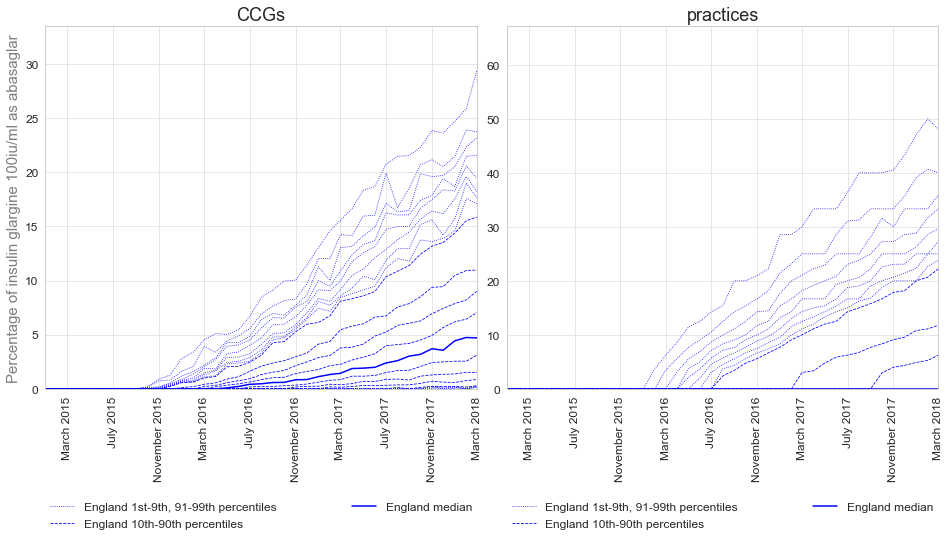

In [31]:
# Plot time series charts of deciles
sns.set_style("whitegrid",{'grid.color': '.9'})
fig = plt.figure(figsize=(16,6.666)) 
gs = gridspec.GridSpec(1,2)  # grid layout for subplots

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,ccg_deciles_df,0,0,'CCGs'), (1,practice_deciles_df,0,1,'practices')]

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s (, sharey=ax)
    for decile in range(1,99):   # plot each decile line
        data = i[1].loc[(i[1]['index']==decile)]
        if decile == 50:
            ax.plot(data["period"],100*data['biosimilar_percent'],'b-',linewidth=1.5, label='England median')
        if decile == 10:
            ax.plot(data["period"],100*data['biosimilar_percent'],'b--',linewidth=0.8,label='England 10th-90th percentiles') 
        if (decile == 1) :
            ax.plot(data["period"],100*data['biosimilar_percent'],'b:',linewidth=0.8, label='England 1st-9th, 91-99th percentiles')
        if ((decile <10) and (decile >1)) | (decile >90):
            ax.plot(data["period"],100*data['biosimilar_percent'],'b:',linewidth=0.8, label='_nolegend_')
        if (decile >10) and (decile <91) and (decile !=50):
            ax.plot(data["period"],100*data['biosimilar_percent'],'b--',linewidth=0.8, label='_nolegend_') 
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Percentage of insulin glargine 100iu/ml as abasaglar', size =15, alpha=0.6)
        
       
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, 100*i[1]['biosimilar_percent'].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
    ax.legend(bbox_to_anchor=(0., -.4, 1., .102), loc=8,
       ncol=2, mode="expand", fontsize=12, borderaxespad=0.)

    
plt.subplots_adjust(wspace = 0.07,hspace = 0.15)
#plt.savefig('Figure 1.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

# 